<a href="https://colab.research.google.com/github/sanailahi1/Image_Search_Engine/blob/main/ML_Project_Image_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive first
* Save progress after the session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # authorizes and mounts Drive


Mounted at /content/drive


#Installing necessary libraries:

In [ ]:
!pip install open_clip_torch
!pip install faiss-cpu
!pip install torch torchvision
!pip install Pillow numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 59.0 MB/s eta 0:00:00


# first downlaod the dataset and obtain the path

*  we first uploaded the kaggle.json file as required by kagglehub
to work properly to get data from kaggle Api
*   then we used `kagglehub` library to **download** the required dataset , and stored its path in the **path** variable



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rahulbhalley/101-objects-categories")

print("Path to dataset files:", path)

100%|██████████| 262M/262M [00:01<00:00, 169MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rahulbhalley/101-objects-categories/versions/1


#Explore the dataset
Check details such as :
* path of the dataset
* dataset_contents
* how many classes our dataset have in total



In [ ]:
import os

path = os.path.join(path,"101_ObjectCategories")
print(path,end='/n/n')
# List the contents of the dataset directory
dataset_contents = os.listdir(path)

# Print the list of files and directories
print(dataset_contents,end='/n/n')

print(f"there are a total of {len(dataset_contents)} categories/classes in this dataset")


/root/.cache/kagglehub/datasets/rahulbhalley/101-objects-categories/versions/1/101_ObjectCategories/n/n['headphone', 'wrench', 'cup', 'crocodile', 'brontosaurus', 'platypus', 'ant', 'cougar_face', 'binocular', 'ferry', 'chandelier', 'dalmatian', 'grand_piano', 'wheelchair', 'car_side', 'gramophone', 'hedgehog', 'mandolin', 'pagoda', 'beaver', 'dolphin', 'kangaroo', 'garfield', 'pigeon', 'butterfly', 'llama', 'brain', 'cougar_body', 'buddha', 'dragonfly', 'Motorbikes', 'scorpion', 'rhino', 'laptop', 'snoopy', 'tick', 'metronome', 'lobster', 'trilobite', 'minaret', 'lotus', 'starfish', 'euphonium', 'ketch', 'stop_sign', 'flamingo_head', 'inline_skate', 'joshua_tree', 'yin_yang', 'electric_guitar', 'dollar_bill', 'flamingo', 'airplanes', 'okapi', 'lamp', 'anchor', 'bonsai', 'barrel', 'pyramid', 'sunflower', 'rooster', 'ibis', 'helicopter', 'umbrella', 'stegosaurus', 'water_lilly', 'scissors', 'Faces_easy', 'crocodile_head', 'windsor_chair', 'accordion', 'watch', 'stapler', 'Faces', 'Leopa

# Importing necessary libraries

In [ ]:
# all the imports necessary
import torch
import open_clip
import faiss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image


# Dataset Preprocessing with OpenCLIP and vectorization in batches to save memory

* Preprocess and vectorize a large image dataset using CLIP in batches to avoid crashing Colab, and save the resulting embeddings.
* **batch preprocessing** refers to the process of collecting and applying data preparation steps to a large volume of data as a single, coordinated group (a "batch"), rather than processing individual data points in real-time. This approach is used to improve efficiency, optimize resource usage, and prepare data for model training

##loading image dataset

In [ ]:

def load_images(dataset_path):
    images = []
    img_paths = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
                full_path = os.path.join(root, file)
                images.append(Image.open(full_path).convert('RGB'))
                img_paths.append(full_path)
    return images, img_paths

images, img_paths = load_images(path)

print(f"Loaded {len(images)} images.")

Loaded 9144 images.


##Split the dataset into training and testing datasets
* 80%  for training  or **vectorizing**
* 20%  for testing  later by querying

In [ ]:
# Split into training (database) and testing (query) sets
train_indices, test_indices = train_test_split(
    np.arange(len(images)),
    test_size=0.2,  # 20% for testing
    random_state=42
)

# Create separate lists
train_images = [images[i] for i in train_indices]
test_images = [images[i] for i in test_indices]

train_paths = [img_paths[i] for i in train_indices]
test_paths = [img_paths[i] for i in test_indices]

print(f"Training set: {len(train_images)} images")
print(f"Test set: {len(test_images)} images")


Training set: 7315 images
Test set: 1829 images


##Preprocess using the OpenClip's preprocess function Make Embeddings
OpenCLIP provides two preprocessing utilities — preprocess_train and preprocess_val — which automatically prepare the dataset for the model’s expected input format.
These functions simplify the workflow by performing several important preprocessing steps that would otherwise need to be done manually:

* Image resizing: adjusts all images to the resolution required by the model.

* Center cropping: ensures a consistent region of interest across images.

* Normalization: scales pixel values to match the distribution used during OpenCLIP’s training.

* Tensor conversion: converts images into properly shaped tensors ready for input to the model.

* Augmentation (for training): applies random transformations like flips or crops to improve generalization.

By using these built-in methods, the dataset becomes fully compatible with OpenCLIP without needing separate preprocessing code. This helps maintain consistency with the original training setup and reduces potential errors when building the image search engine.

In [ ]:
# Load OpenCLIP model
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_e16')
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

def batch_encode_images(img_list, preprocess, model, batch_size=32, device="cuda"):
    all_features = []
    n_images = len(img_list)
    for start_idx in range(0, n_images, batch_size):
        end_idx = min(start_idx + batch_size, n_images)
        batch_imgs = img_list[start_idx:end_idx]

        # Preprocess this batch
        batch_preprocessed = torch.stack([preprocess(img) for img in batch_imgs]).to(device)

        # Encode with model (no gradients needed)
        with torch.no_grad():
            batch_features = model.encode_image(batch_preprocessed).cpu().numpy()

        all_features.append(batch_features)
        print(f"Processed batch {start_idx} to {end_idx-1} of {n_images}")

    # Concatenate to single numpy array
    features_array = np.concatenate(all_features, axis=0)
    return features_array


train_features = batch_encode_images(train_images, preprocess_train, model, batch_size=32, device=device)
test_features = batch_encode_images(test_images, preprocess_val, model, batch_size=32, device=device)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Processed batch 0 to 31 of 7315
Processed batch 32 to 63 of 7315
Processed batch 64 to 95 of 7315
Processed batch 96 to 127 of 7315
Processed batch 128 to 159 of 7315
Processed batch 160 to 191 of 7315
Processed batch 192 to 223 of 7315
Processed batch 224 to 255 of 7315
Processed batch 256 to 287 of 7315
Processed batch 288 to 319 of 7315
Processed batch 320 to 351 of 7315
Processed batch 352 to 383 of 7315
Processed batch 384 to 415 of 7315
Processed batch 416 to 447 of 7315
Processed batch 448 to 479 of 7315
Processed batch 480 to 511 of 7315
Processed batch 512 to 543 of 7315
Processed batch 544 to 575 of 7315
Processed batch 576 to 607 of 7315
Processed batch 608 to 639 of 7315
Processed batch 640 to 671 of 7315
Processed batch 672 to 703 of 7315
Processed batch 704 to 735 of 7315
Processed batch 736 to 767 of 7315
Processed batch 768 to 799 of 7315
Processed batch 800 to 831 of 7315
Processed batch 832 to 863 of 7315
Processed batch 864 to 895 of 7315
Processed batch 896 to 927 o

##Visualization of Embeddings ,
* using dimentionality reduction techniques such as PCA ,T-SNE to plot high-dimensional embeddings on 2d/3d spaces


### t-SNE (2D)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7315 samples in 0.002s...
[t-SNE] Computed neighbors for 7315 samples in 3.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7315
[t-SNE] Computed conditional probabilities for sample 2000 / 7315
[t-SNE] Computed conditional probabilities for sample 3000 / 7315
[t-SNE] Computed conditional probabilities for sample 4000 / 7315
[t-SNE] Computed conditional probabilities for sample 5000 / 7315
[t-SNE] Computed conditional probabilities for sample 6000 / 7315
[t-SNE] Computed conditional probabilities for sample 7000 / 7315
[t-SNE] Computed conditional probabilities for sample 7315 / 7315
[t-SNE] Mean sigma: 2.108540
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.199539
[t-SNE] KL divergence after 2000 iterations: 0.812189


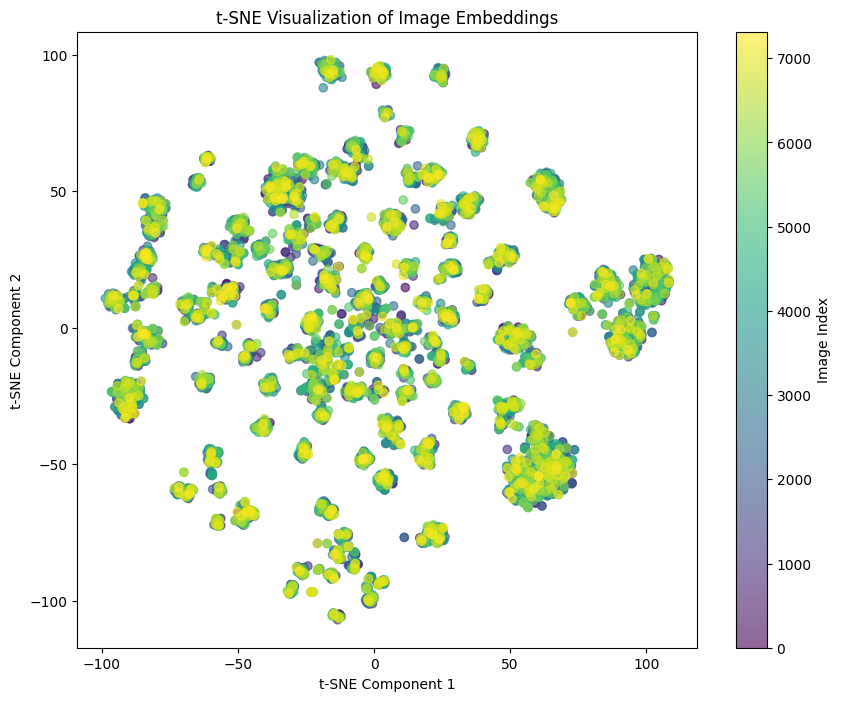

KL Divergence: 0.8121885061264038


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Reduce embeddings from high dimensions to 2D
tsne = TSNE(n_components=2,
            perplexity=30,
            n_iter=2000,
            learning_rate=200,
            init='pca',
            random_state=42,
            verbose=1)
embeddings_2d = tsne.fit_transform(train_features)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=range(len(embeddings_2d)), cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Image Index')
plt.title('t-SNE Visualization of Image Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.savefig(f'/tsne_2d.png', dpi=300)
plt.show()

print(f"KL Divergence: {tsne.kl_divergence_}")


###PCA (2D)

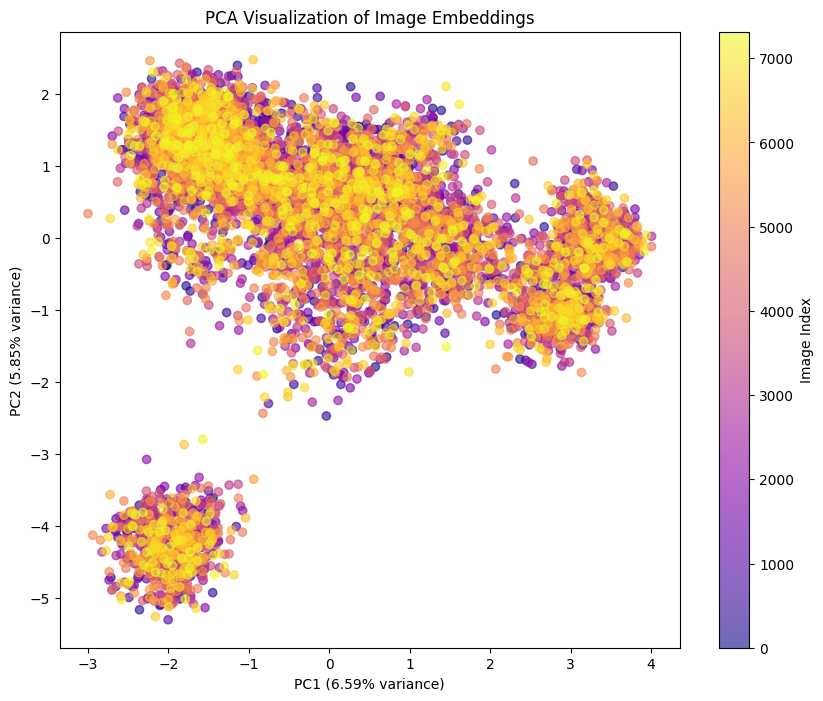

In [ ]:
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(train_features)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1],
                     c=range(len(embeddings_pca)), cmap='plasma', alpha=0.6)
plt.colorbar(scatter, label='Image Index')
plt.title('PCA Visualization of Image Embeddings')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.savefig(f'pca_2d.png', dpi=300)
plt.show()


### 3D t-SNE

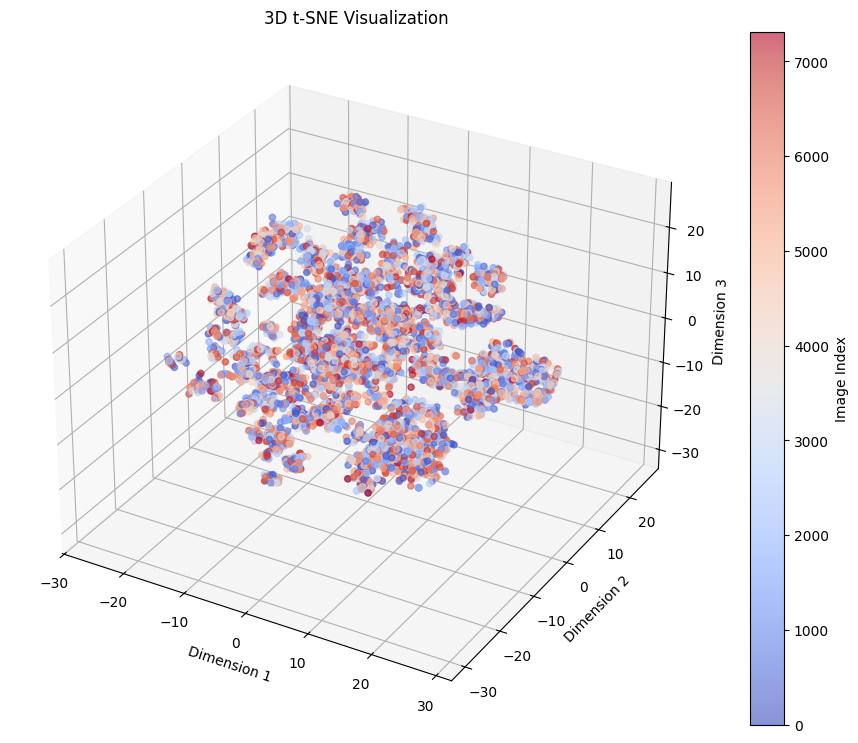

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# 3D t-SNE
tsne_3d = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne_3d.fit_transform(train_features)

# Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],
                    c=range(len(embeddings_3d)), cmap='coolwarm', alpha=0.6)
ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.colorbar(scatter, label='Image Index')
plt.savefig(f'tsne_3d.png', dpi=300)
plt.show()


###interpretation of visualizations:
“These visualizations demonstrate that OpenCLIP effectively converts image data into a meaningful vector space. The t-SNE plots (2D and 3D) show local relationships and clustering patterns between similar images, while the PCA plot shows the overall variance and structure in the dataset. Together, they confirm that OpenCLIP’s embeddings capture both visual and semantic similarities, validating that the model’s preprocessing and encoding steps are working as intended.”

##store Embeddings using FAISS indexing
* FAISS is a vector database used for storing the generated embedding for efficient retrieval  

In [ ]:
# Build FAISS index with training data
index = faiss.IndexFlatL2(train_features.shape[1])
index.add(train_features)

print(f"FAISS index built with {index.ntotal} training images")

FAISS index built with 7315 training images


##Make labels for testing

In [ ]:
import os

def extract_labels_from_paths(paths):
    """
    Extract class labels from file paths
    Example: '/path/to/dataset/cats/img1.jpg' -> 'cats'
    """
    labels = []
    for path in paths:
        # Get parent folder name as label
        label = os.path.basename(os.path.dirname(path))
        labels.append(label)
    return labels

# Extract labels from your paths
train_labels = extract_labels_from_paths(train_paths)
test_labels = extract_labels_from_paths(test_paths)

print(f"Found {len(set(train_labels))} unique categories")


Found 102 unique categories


In [ ]:
def get_ground_truth_from_labels(query_label, train_labels):
    """
    Returns indices of all training images with same label as query
    """
    relevant_indices = [i for i, label in enumerate(train_labels) if label == query_label]
    return relevant_indices

# Example: Create ground truth for all test queries
actual_relevant = []

for i, test_label in enumerate(test_labels):
    # Find all training images with same label as this test image
    ground_truth = get_ground_truth_from_labels(test_label, train_labels)
    actual_relevant.append(ground_truth)

print(f"Example - Query 0 has {len(actual_relevant[0])} relevant images in training set")


Example - Query 0 has 646 relevant images in training set


#Testing the model

In [ ]:
def search_and_get_predictions(query_features, index, k=20):
    """
    Search FAISS index and return predicted indices
    """
    distances, indices = index.search(query_features, k)
    return indices

# Get predictions for all test queries
k = 20  # Retrieve top 20 similar images
predicted_indices = search_and_get_predictions(test_features, index, k)

print(f"Predicted shape: {predicted_indices.shape}")  # (num_test_queries, k)


Predicted shape: (1829, 20)


##Testing PipeLine

In [ ]:
# Evaluation functions
def precision_at_k(actual, predicted, k):
    if len(predicted) > k:
        predicted = predicted[:k]
    num_hits = sum([1 for p in predicted if p in actual])
    return num_hits / min(len(predicted), k) if k != 0 else 0.0

def recall_at_k(actual, predicted, k):
    if len(predicted) > k:
        predicted = predicted[:k]
    num_hits = sum([1 for p in predicted if p in actual])
    return num_hits / len(actual) if len(actual) != 0 else 0.0

def average_precision_at_k(actual, predicted, k):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k) if len(actual) != 0 else 0.0

# Evaluate on all test queries
k_values = [5, 10, 20]
results = {k: {'precision': [], 'recall': [], 'ap': []} for k in k_values}

for query_idx in range(len(test_images)):
    actual = actual_relevant[query_idx]  # Ground truth indices
    predicted = predicted_indices[query_idx].tolist()  # Search results

    for k in k_values:
        prec = precision_at_k(actual, predicted, k)
        rec = recall_at_k(actual, predicted, k)
        ap = average_precision_at_k(actual, predicted, k)

        results[k]['precision'].append(prec)
        results[k]['recall'].append(rec)
        results[k]['ap'].append(ap)

# Print average metrics
print("\nEvaluation Results:")
for k in k_values:
    print(f"\n--- Top-{k} Results ---")
    print(f"Precision@{k}: {np.mean(results[k]['precision']):.4f}")
    print(f"Recall@{k}: {np.mean(results[k]['recall']):.4f}")
    print(f"MAP@{k}: {np.mean(results[k]['ap']):.4f}")



Evaluation Results:

--- Top-5 Results ---
Precision@5: 0.8837
Recall@5: 0.0647
MAP@5: 0.8622

--- Top-10 Results ---
Precision@10: 0.8675
Recall@10: 0.1261
MAP@10: 0.8381

--- Top-20 Results ---
Precision@20: 0.8406
Recall@20: 0.2407
MAP@20: 0.7999


##Visualizing Results

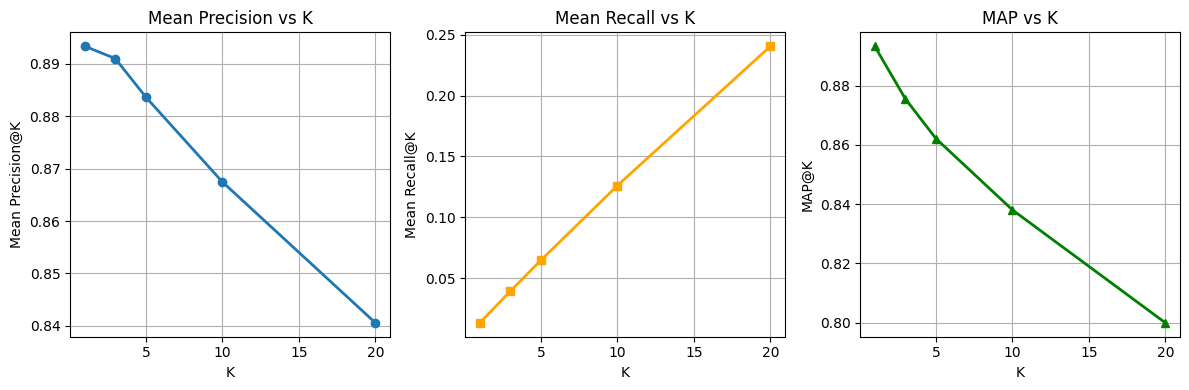

In [ ]:
# Calculate metrics for different K values
k_values = [1, 3, 5, 10, 20]
precision_scores = []
recall_scores = []
map_scores = []

for k in k_values:
    precisions_k = [precision_at_k(a, p, k) for a, p in zip(actual_relevant, predicted_indices)]
    recalls_k = [recall_at_k(a, p, k) for a, p in zip(actual_relevant, predicted_indices)]
    aps_k = [average_precision_at_k(a, p, k) for a, p in zip(actual_relevant, predicted_indices)]

    precision_scores.append(np.mean(precisions_k))
    recall_scores.append(np.mean(recalls_k))
    map_scores.append(np.mean(aps_k))

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(k_values, precision_scores, marker='o', linewidth=2)
plt.xlabel('K')
plt.ylabel('Mean Precision@K')
plt.title('Mean Precision vs K')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(k_values, recall_scores, marker='s', linewidth=2, color='orange')
plt.xlabel('K')
plt.ylabel('Mean Recall@K')
plt.title('Mean Recall vs K')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(k_values, map_scores, marker='^', linewidth=2, color='green')
plt.xlabel('K')
plt.ylabel('MAP@K')
plt.title('MAP vs K')
plt.grid(True)

plt.tight_layout()
plt.savefig(f'evaluation_metrics.png', dpi=300)
plt.show()

## Search Results visualization

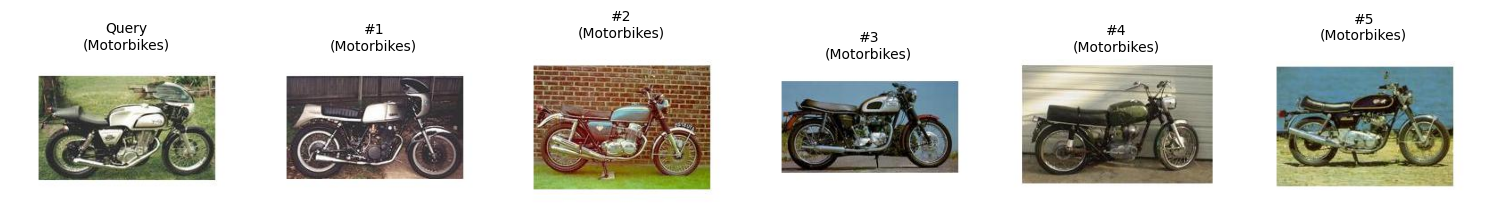

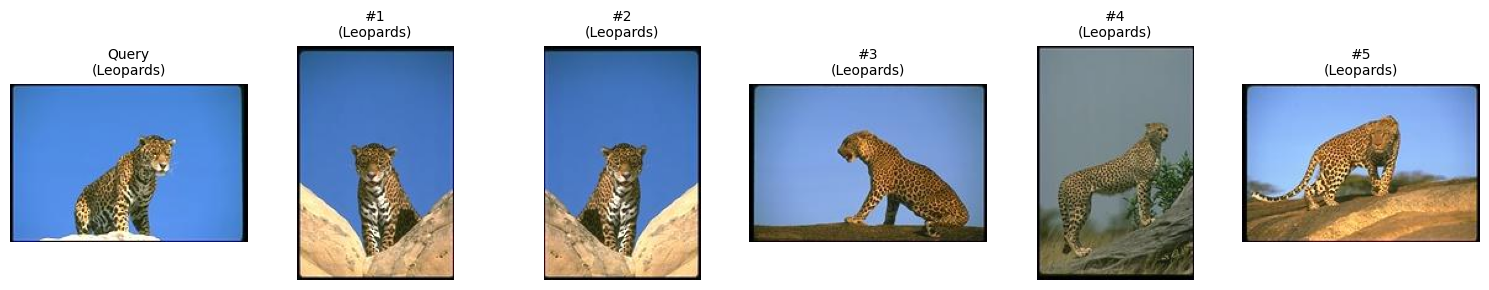

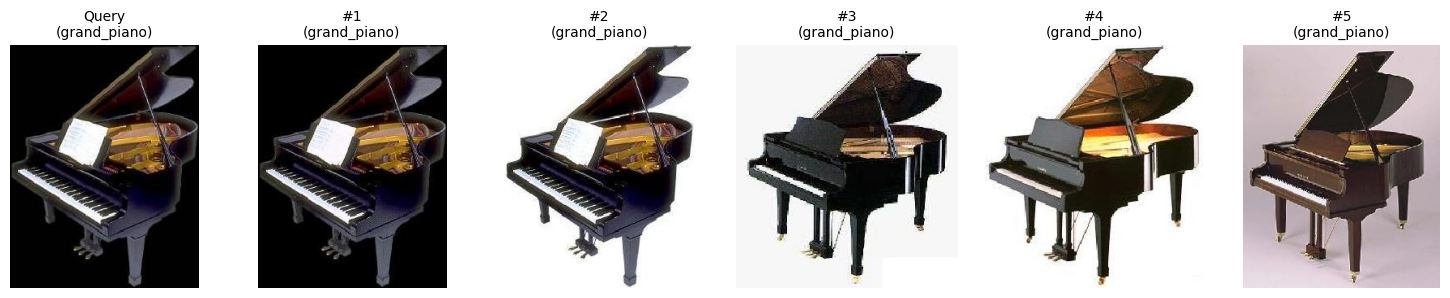

In [ ]:

# example query with results
def visualize_search_results(query_idx, num_results=5):
    query_image = test_images[query_idx]
    query_label = test_labels[query_idx]
    predicted = predicted_indices[query_idx][:num_results]
    actual = actual_relevant[query_idx]

    fig, axes = plt.subplots(1, num_results+1, figsize=(15, 3))

    # Query image
    axes[0].imshow(query_image)
    axes[0].set_title(f"Query\n({query_label})", fontsize=10)
    axes[0].axis('off')

    # Retrieved images
    for i, pred_idx in enumerate(predicted):
        result_image = train_images[pred_idx]
        result_label = train_labels[pred_idx]

        # Check if relevant (correct)
        is_relevant = pred_idx in actual
        border_color = 'green' if is_relevant else 'red'

        axes[i+1].imshow(result_image)
        axes[i+1].set_title(f"#{i+1}\n({result_label})", fontsize=10)
        axes[i+1].axis('off')

        # Add colored border
        for spine in axes[i+1].spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)

    plt.tight_layout()
    plt.savefig(f"query_{query_idx}_results.png", dpi=300, bbox_inches='tight')
    plt.show()

# Visualize first 3 queries
for i in range(3):
    visualize_search_results(i)


##(Optionally) Search the model by Text

Text Query: 'photo of a old computer'
Rank 1: /root/.cache/kagglehub/datasets/rahulbhalley/101-objects-categories/versions/1/101_ObjectCategories/BACKGROUND_Google/image_0428.jpg | Label: BACKGROUND_Google | Score (lower=better): 84.1855
Rank 2: /root/.cache/kagglehub/datasets/rahulbhalley/101-objects-categories/versions/1/101_ObjectCategories/laptop/image_0061.jpg | Label: laptop | Score (lower=better): 92.4043
Rank 3: /root/.cache/kagglehub/datasets/rahulbhalley/101-objects-categories/versions/1/101_ObjectCategories/BACKGROUND_Google/image_0139.jpg | Label: BACKGROUND_Google | Score (lower=better): 93.0776
Rank 4: /root/.cache/kagglehub/datasets/rahulbhalley/101-objects-categories/versions/1/101_ObjectCategories/laptop/image_0055.jpg | Label: laptop | Score (lower=better): 93.1501
Rank 5: /root/.cache/kagglehub/datasets/rahulbhalley/101-objects-categories/versions/1/101_ObjectCategories/laptop/image_0043.jpg | Label: laptop | Score (lower=better): 93.1689


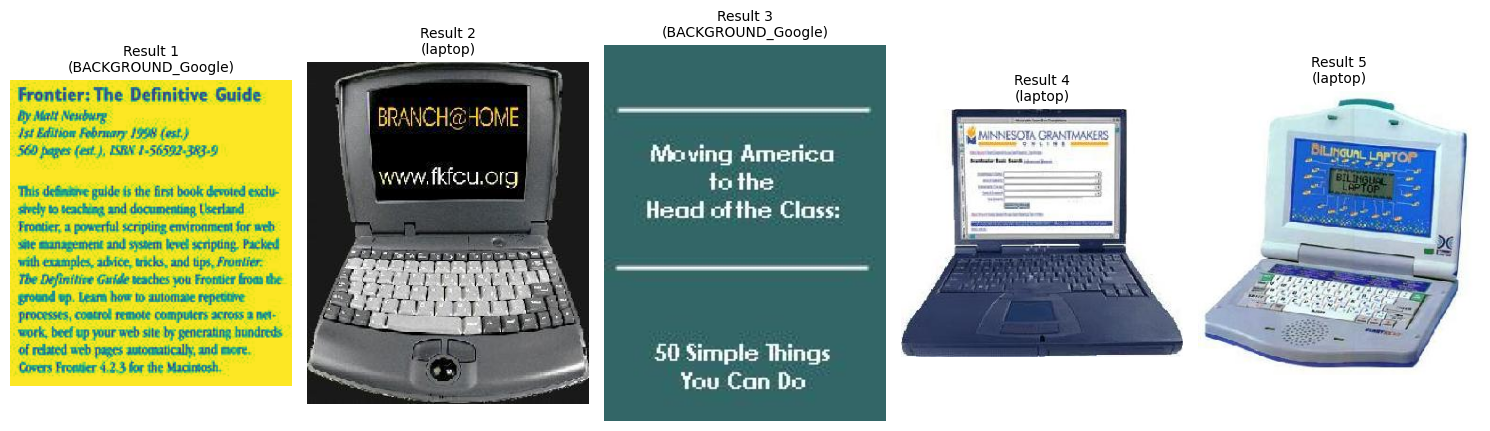

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


def search_images_by_text(
    text_query, model, tokenizer, index, train_images, train_paths, train_labels, k=5, device="cuda"
):
    # Tokenize and encode the text query
    with torch.no_grad():
        text_tokens = tokenizer([text_query]).to(device)
        text_feature = model.encode_text(text_tokens)
        text_feature_np = text_feature.cpu().numpy()  # Shape: (1, emb_dim)


    # Search for similar images in FAISS index
    distances, indices = index.search(text_feature_np, k)
    retrieved_indices = indices[0]  # Top-k image indices in train set

    # Display results
    print(f"Text Query: '{text_query}'")
    plt.figure(figsize=(15, 5))
    for rank, idx in enumerate(retrieved_indices):
        img_path = train_paths[idx]
        img_label = train_labels[idx]
        distance = distances[0][rank]

        print(
            f"Rank {rank+1}: {img_path} | Label: {img_label} | Score (lower=better): {distance:.4f}"
        )

        # Display retrieved images
        plt.subplot(1, k, rank + 1)
        retrieved_image = Image.open(img_path)
        plt.imshow(retrieved_image)
        plt.title(f"Result {rank+1}\n({img_label})", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    return retrieved_indices

# Example usage:
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = open_clip.get_tokenizer('ViT-B-32')

query = "photo of a old computer"
top_indices = search_images_by_text(
    query, model, tokenizer, index, train_images, train_paths, train_labels, k=5, device=device
)

#Saving embeddings and paths

In [ ]:


import os


# Save embeddings + paths
import pickle
with open("image_embeddings.pkl", "wb") as f:
    pickle.dump({'features': train_features, 'paths': train_paths}, f)

# Save FAISS index
import faiss
faiss.write_index(index, "faiss_index.bin")


#reload and demo
* reload the saved image embeddings , index
* give demo by querying with a text

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Top results:
1. /root/.cache/kagglehub/datasets/rahulbhalley/101-objects-categories/versions/1/101_ObjectCategories/BACKGROUND_Google/image_0450.jpg  (distance=77.7401)
2. /root/.cache/kagglehub/datasets/rahulbhalley/101-objects-categories/versions/1/101_ObjectCategories/BACKGROUND_Google/image_0066.jpg  (distance=78.7852)
3. /root/.cache/kagglehub/datasets/rahulbhalley/101-objects-categories/versions/1/101_ObjectCategories/bonsai/image_0089.jpg  (distance=79.1176)
4. /root/.cache/kagglehub/datasets/rahulbhalley/101-objects-categories/versions/1/101_ObjectCategories/Motorbikes/image_0462.jpg  (distance=79.7581)
5. /root/.cache/kagglehub/datasets/rahulbhalley/101-objects-categories/versions/1/101_ObjectCategories/BACKGROUND_Google/image_0129.jpg  (distance=80.3328)


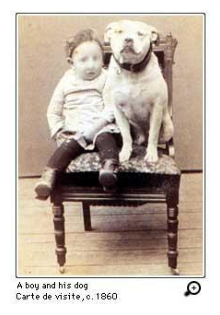

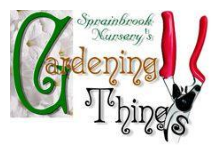

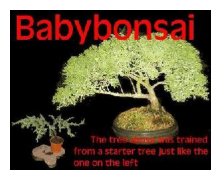

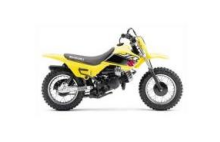

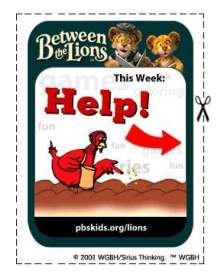

In [ ]:
# Reload artifacts

from google.colab import drive
drive.mount('/content/drive')



import pickle, faiss, torch, open_clip
with open("image_embeddings.pkl", "rb") as f:
    data = pickle.load(f)
    train_features = data['features']
    train_paths = data['paths']

index = faiss.read_index("faiss_index.bin")

# Recreate model + tokenizer
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_e16')
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

# Quick text->image search demo
text_query = "a photo of a dog sitting with a baby "
with torch.no_grad():
    text_tokens = tokenizer([text_query]).to(device)
    text_feat = model.encode_text(text_tokens).cpu().numpy()
D, I = index.search(text_feat, k=5)
print("Top results:")
for rank, idx in enumerate(I[0]):
    print(f"{rank+1}. {train_paths[idx]}  (distance={D[0][rank]:.4f})")
    from PIL import Image
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 5, rank + 1)

    plt.axis('off')
    image = Image.open(train_paths[idx])
    plt.imshow(image)
